## XGBoost Model for Wait Time Prediction

This model uses gradient boosting to capture complex patterns in wait time data, including temporal features, weather effects, and holiday impacts.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from datetime import datetime, timedelta

# Define consistent colors for plots
TRAIN_COLOR = 'steelblue'
TRAIN_FILL_COLOR = 'steelblue'
TRAIN_FILL_ALPHA = 0.3
VAL_COLOR = 'coral'
VAL_FILL_COLOR = 'coral'
VAL_FILL_ALPHA = 0.3

# Load and preprocess data using the same functions as before

In [75]:
def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    # Filter for the specified ride
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    ride_data.loc[:, "closed"] = ride_data["closed"].astype(bool).astype(int)
    
    # Resample to 30-minute intervals
    ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    
    # Remove off-season data (January-March)
    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    return ride_data

def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    # Identify and remove fully closed days
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]
    
    # Identify and remove days with zero wait times
    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data

def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    # Determine operating hours from data where wait times > 0
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()
    
    # Extract opening and closing hours
    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour
    
    # Set reasonable boundaries for operating hours
    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)
    
    # Create date-to-hours mapping
    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])
    
    # Filter data to operating hours only
    def is_operating_hour(timestamp):
        date = timestamp.date()
        if date not in date_to_hours:
            # Handle dates not found in mapping
            return 0
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data

# Enhanced feature engineering for the XGBoost model

In [76]:
def prepare_data_for_xgboost(ride_data):
    """Transform data with enhanced features for XGBoost model."""
    # Start with baseline features
    data = ride_data.copy()
    data = data.rename(columns={"timestamp": "ds", "wait_time": "y"})
    
    # Extract basic datetime features
    data['hour'] = data['ds'].dt.hour
    data['minute'] = data['ds'].dt.minute
    data['day_of_week'] = data['ds'].dt.dayofweek
    data['month'] = data['ds'].dt.month
    data['day_of_month'] = data['ds'].dt.day
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Create cyclical time features to capture periodicity
    # These help the model understand that hour 23 is close to hour 0
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    
    # Time of day features
    data['morning_rush'] = ((data['hour'] >= 9) & (data['hour'] <= 11)).astype(int)
    data['lunch_time'] = ((data['hour'] >= 12) & (data['hour'] <= 14)).astype(int)
    data['afternoon_rush'] = ((data['hour'] >= 15) & (data['hour'] <= 17)).astype(int)
    data['evening'] = (data['hour'] >= 18).astype(int)
    
    # Weather features
    if 'temperature' in data.columns:
        data['temp_squared'] = data['temperature'] ** 2
        data['high_temp'] = (data['temperature'] > 25).astype(int)
        data['moderate_temp'] = ((data['temperature'] >= 15) & (data['temperature'] <= 25)).astype(int)
        data['low_temp'] = (data['temperature'] < 15).astype(int)
    
    if 'rain' in data.columns:
        data['any_rain'] = (data['rain'] > 0).astype(int)
        data['heavy_rain'] = (data['rain'] > 5).astype(int)
    
    # Interaction features
    data['weekend_morning'] = data['is_weekend'] * data['morning_rush']
    data['weekend_afternoon'] = data['is_weekend'] * data['afternoon_rush']
    if 'temperature' in data.columns and 'rain' in data.columns:
        data['temp_weekend'] = data['temperature'] * data['is_weekend']
        data['rain_weekend'] = data['rain'] * data['is_weekend']
    
    # Season features
    data['spring'] = data['month'].isin([4, 5, 6]).astype(int)
    data['summer'] = data['month'].isin([7, 8, 9]).astype(int)
    data['fall'] = data['month'].isin([10, 11, 12]).astype(int)
    
    return data


# Helper function to create lag features

In [77]:
def add_lag_features(df, lagged_features, lag_periods):
    """Add lagged features to the dataframe."""
    df_with_lags = df.copy()
    
    # Group by day of week and hour to get "same time last week" features
    df_sorted = df.sort_values('ds')
    
    # Create lag features for each specified period
    for feature in lagged_features:
        if feature in df.columns:
            for lag in lag_periods:
                col_name = f'{feature}_lag_{lag}'
                # Shift the sorted dataframe 
                df_with_lags[col_name] = df_sorted[feature].shift(lag)
    
    # Forward fill missing lag values
    df_with_lags = df_with_lags.ffill()
    
    return df_with_lags

# Custom XGBoost model for wait time prediction

In [78]:
# Version-Safe XGBoost model with hyperparameter optimization and cross-validation
class VersionSafeXGBoostModel:
    """XGBoost model that works with different XGBoost API versions while maintaining advanced features."""
    def __init__(self, lag_periods=[48, 96, 336, 672], lagged_features=['y']):
        self.lag_periods = lag_periods
        self.lagged_features = lagged_features
        self.model = None
        self.feature_columns = None
        
    def fit(self, train_data, n_estimators=500, verbose=True):
        """Train the XGBoost model with version-safe parameters."""
        # Start timing
        import time
        start_time = time.time()
        
        # Apply feature engineering
        print("Applying feature engineering...")
        self.train_data = prepare_data_for_xgboost(train_data)
        
        # Add lag features
        print("Adding lag features...")
        self.train_data_with_lags = add_lag_features(
            self.train_data, 
            self.lagged_features, 
            self.lag_periods
        )
        
        # Drop rows with NaN values from lags
        self.train_data_with_lags = self.train_data_with_lags.dropna()
        
        # Select numeric features only
        numeric_columns = self.train_data_with_lags.select_dtypes(include=['number']).columns.tolist()
        self.feature_columns = [col for col in numeric_columns 
                               if col not in ['ds', 'y']]
        
        print(f"Using {len(self.feature_columns)} numeric features for training")
        
        # Create training matrices
        X = self.train_data_with_lags[self.feature_columns]
        y = self.train_data_with_lags['y']
        
        # Fill NaN values
        if X.isna().any().any():
            print("Filling NaN values in input features...")
            X = X.fillna(0)
            
        # Version-safe parameter settings
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'n_estimators': n_estimators,
            'random_state': 42
        }
        
        print("Training XGBoost model with the following parameters:")
        for param, value in params.items():
            print(f"  {param}: {value}")
            
        # Create the model
        self.model = xgb.XGBRegressor(**params)
        
        # Fit the model with a basic, version-safe approach
        print(f"\nTraining with {n_estimators} boosting rounds...")
        start_training = time.time()
        
        # Simple safe fit
        self.model.fit(X, y)
        
        training_time = time.time() - start_training
        print(f"Training completed in {training_time:.2f} seconds")
        
        # Calculate total time
        total_time = time.time() - start_time
        print(f"Total processing time: {total_time:.2f} seconds")
        
        # Calculate standard deviation for confidence intervals
        self.train_std = y.std()
        
        # Feature importance analysis
        feature_importance = self.model.feature_importances_
        self.feature_importance = pd.DataFrame({
            'Feature': self.feature_columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 most important features:")
        print(self.feature_importance.head(10))
        
        return self
    
    def cross_validate(self, train_data, n_splits=5):
        """Perform time-series cross-validation in a version-safe manner."""
        from sklearn.model_selection import TimeSeriesSplit
        from sklearn.metrics import mean_squared_error, mean_absolute_error
        import numpy as np
        
        print(f"\nPerforming {n_splits}-fold time series cross-validation...")
        
        # Prepare data
        processed_data = prepare_data_for_xgboost(train_data)
        data_with_lags = add_lag_features(processed_data, self.lagged_features, self.lag_periods)
        data_with_lags = data_with_lags.dropna().sort_values('ds')
        
        # Select features
        numeric_columns = data_with_lags.select_dtypes(include=['number']).columns.tolist()
        feature_cols = [col for col in numeric_columns if col not in ['ds', 'y']]
        
        X = data_with_lags[feature_cols]
        y = data_with_lags['y']
        
        # Set up cross-validation
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        # Track metrics
        cv_rmse = []
        cv_mae = []
        
        # Parameters for the model
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.05,
            'max_depth': 6,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0,
            'reg_alpha': 0.1,
            'reg_lambda': 1,
            'random_state': 42,
            'n_estimators': 200  # Use fewer trees for CV to be faster
        }
        
        # Perform cross-validation
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train the model with version-safe fit
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_val)
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)
            
            cv_rmse.append(rmse)
            cv_mae.append(mae)
            
            print(f"Fold {fold+1}: RMSE = {rmse:.2f}, MAE = {mae:.2f}")
        
        # Report average metrics
        avg_rmse = np.mean(cv_rmse)
        avg_mae = np.mean(cv_mae)
        print(f"\nCross-validation results: Avg RMSE = {avg_rmse:.2f}, Avg MAE = {avg_mae:.2f}")
        
        return {'rmse': cv_rmse, 'mae': cv_mae, 'avg_rmse': avg_rmse, 'avg_mae': avg_mae}
    
    def tune_hyperparameters(self, train_data, param_grid=None, n_iter=10):
        """Perform hyperparameter tuning in a version-safe manner."""
        from sklearn.model_selection import RandomizedSearchCV
        from sklearn.metrics import make_scorer, mean_squared_error
        import numpy as np
        
        print("\nPerforming hyperparameter tuning...")
        
        # Start timing
        import time
        start_time = time.time()
        
        # Prepare data
        processed_data = prepare_data_for_xgboost(train_data)
        data_with_lags = add_lag_features(processed_data, self.lagged_features, self.lag_periods)
        data_with_lags = data_with_lags.dropna().sort_values('ds')
        
        # Select features
        numeric_columns = data_with_lags.select_dtypes(include=['number']).columns.tolist()
        feature_cols = [col for col in numeric_columns if col not in ['ds', 'y']]
        
        X = data_with_lags[feature_cols]
        y = data_with_lags['y']
        
        # Default parameter grid if none provided
        if param_grid is None:
            param_grid = {
                'learning_rate': [0.01, 0.05, 0.1],
                'max_depth': [3, 5, 7],
                'min_child_weight': [1, 3, 5],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'n_estimators': [100, 200, 300]
            }
        
        # Create the base model
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            random_state=42
        )
        
        # Create the scoring function
        def rmse_scorer(estimator, X, y):
            y_pred = estimator.predict(X)
            return -np.sqrt(mean_squared_error(y, y_pred))
        
        # Set up the randomized search
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring=rmse_scorer,
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        
        # Fit the random search
        print(f"Trying {n_iter} combinations of parameters...")
        random_search.fit(X, y)
        
        # Report results
        print(f"\nBest parameters found: {random_search.best_params_}")
        print(f"Best RMSE: {-random_search.best_score_:.2f}")
        
        # Update model with best parameters
        self.best_params = random_search.best_params_
        
        # Train a fresh model with the best parameters
        print("Training final model with best parameters...")
        self.model = xgb.XGBRegressor(**self.best_params, random_state=42)
        self.model.fit(X, y)
        
        # Calculate total time
        total_time = time.time() - start_time
        print(f"Total hyperparameter tuning time: {total_time:.2f} seconds")
        
        # Update feature importance
        self.feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': self.model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 features after tuning:")
        print(self.feature_importance.head(10))
        
        return random_search
    
    def predict(self, future_df):
        """Generate predictions with confidence intervals."""
        # Start with both training and future data combined
        all_data = pd.concat([self.train_data, future_df])
        all_data = all_data.sort_values('ds').reset_index(drop=True)
        
        # Prepare future data with the same feature engineering
        future_with_features = prepare_data_for_xgboost(all_data)
        
        # Add lag features
        future_with_lags = add_lag_features(
            future_with_features, 
            self.lagged_features, 
            self.lag_periods
        )
        
        # Filter to only prediction dates
        future_dates = future_df['ds'].values
        future_with_lags = future_with_lags[future_with_lags['ds'].isin(future_dates)]
        
        # Handle any remaining NaN values
        for col in self.feature_columns:
            if col in future_with_lags.columns:
                if col in self.train_data_with_lags.columns:
                    mean_val = self.train_data_with_lags[col].mean()
                    if pd.isna(mean_val):
                        mean_val = 0
                else:
                    mean_val = 0
                future_with_lags[col] = future_with_lags[col].fillna(mean_val)
        
        # Make predictions
        X_future = future_with_lags[self.feature_columns]
        
        # Fill any remaining NaNs 
        X_future = X_future.fillna(0)
        
        predictions = self.model.predict(X_future)
        
        # Create prediction dataframe
        forecast = pd.DataFrame({
            'ds': future_with_lags['ds'],
            'yhat': predictions,
            'yhat_lower': np.maximum(0, predictions - 1.96 * self.train_std),
            'yhat_upper': predictions + 1.96 * self.train_std
        })
        
        return forecast

# Helper functions for evaluation and visualization (reused from before)

In [79]:
def combine_forecast_with_actual(forecast, train_data, val_data):
    """Combine forecast with actual data for visualization."""
    forecast.index = pd.to_datetime(forecast.ds)
    
    train_data.index = pd.to_datetime(train_data.ds)
    val_data.index = pd.to_datetime(val_data.ds)
    
    data = pd.concat([train_data, val_data], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

def post_process_forecast(forecast, closed_data):
    """Apply corrections to forecasted values."""
    # Set predictions to zero during known closures
    closed_mask = forecast['ds'].isin(closed_data.loc[closed_data['closed'] == 1, 'ds'])
    forecast.loc[closed_mask, 'yhat'] = 0
    forecast.loc[closed_mask, 'yhat_lower'] = 0
    forecast.loc[closed_mask, 'yhat_upper'] = 0
    
    # Correct negative predictions
    negative_mask = forecast['yhat'] < 0
    forecast.loc[negative_mask, 'yhat'] = 0
    forecast.loc[negative_mask, 'yhat_lower'] = 0
    forecast.loc[negative_mask, 'yhat_upper'] = 0
    
    return forecast

def plot_forecast_comparison(forecast_data, split_year, show_uncertainty=True, model_name="Model"):
    """Plot forecasts against actual data with training/validation split."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Training period
    train = forecast_data.loc[:str(split_year - 1),:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color=TRAIN_COLOR, lw=0.5)
    if show_uncertainty:
        ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, 
                        color=TRAIN_FILL_COLOR, alpha=TRAIN_FILL_ALPHA)
    
    # Validation period
    val = forecast_data.loc[str(split_year):,:]
    ax.plot(val.index, val.y, 'ro', markersize=3)
    ax.plot(val.index, val.yhat, color=VAL_COLOR, lw=0.5)
    if show_uncertainty:
        ax.fill_between(val.index, val.yhat_lower, val.yhat_upper, 
                        color=VAL_FILL_COLOR, alpha=VAL_FILL_ALPHA)
        
    # Add year divider
    ax.axvline(pd.Timestamp(f'{split_year}-01-01'), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=6, label='Training Actual'),
        Line2D([0], [0], color=TRAIN_COLOR, lw=2, label='Training Forecast'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6, label='Validation Actual'),
        Line2D([0], [0], color=VAL_COLOR, lw=2, label='Validation Forecast')
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title(f'{model_name} Wait Time Forecast: Training vs Validation (Split at {split_year})', fontsize=14)
    ax.set_ylabel('Wait Time (minutes)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    return fig

def calculate_error_metrics(forecast, val_data):
    """Calculate and display error metrics for model evaluation."""
    # Filter forecast to validation period
    val_forecast = forecast[forecast['ds'].isin(val_data['ds'])].fillna(0)
    
    # Calculate metrics
    mae = mean_absolute_error(val_forecast["y"], val_forecast["yhat"])
    mse = mean_squared_error(val_forecast['y'], val_forecast['yhat'])
    rmse = np.sqrt(mse)
    
    # Standard MAPE calculation - handle zeros with epsilon to avoid division by zero
    epsilon = 1e-8
    abs_pct_errors = np.abs(val_forecast['y'] - val_forecast['yhat']) / (np.abs(val_forecast['y']) + epsilon)
    # Only include points where actual values are non-zero
    non_zero_mask = val_forecast['y'] > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    
    within_ci = ((val_forecast['y'] >= val_forecast['yhat_lower']) & 
                 (val_forecast['y'] <= val_forecast['yhat_upper'])).mean() * 100
    
    print(f"MAE (Mean Absolute Error): {mae:.2f} minutes")
    print(f"RMSE (Root-Mean-Square Deviation): {rmse:.2f} minutes")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"Percentage of predictions within confidence interval: {within_ci:.2f}%")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'within_ci': within_ci}

def plot_feature_importance(model, feature_names, top_n=20):
    """Plot the top N most important features"""
    importance = model.feature_importances_
    indices = np.argsort(importance)[-top_n:]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importance[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Top Feature Importance')
    plt.tight_layout()
    plt.savefig("xgboost_feature_importance.png")
    plt.show()

# Run the complete analysis with the enhanced XGBoost model

In [80]:
# Load data
input_file = "../data/processed/ep/merged_with_holidays.parquet"
ride_name = "silver star"

# Process ride data (same as in Prophet model)
ride_df = load_ride_data(input_file, ride_name)
print(f"Initial ride data shape: {ride_df.shape}")

# Remove closed days and days with zero wait times
ride_df = remove_closed_and_zero_wait_days(ride_df)
print(f"After removing closed/zero days: {ride_df.shape}")

# Filter to operating hours only
ride_df = filter_to_operating_hours(ride_df)
print(f"After filtering to operating hours: {ride_df.shape}")

# Prepare baseline data
baseline_df = prepare_data_for_xgboost(ride_df)
print(f"Prepared data shape: {baseline_df.shape}")

C:\Users\Nevin\AppData\Local\Temp\ipykernel_14688\1043216636.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  ride_data.loc[:, "closed"] = ride_data["closed"].astype(bool).astype(int)


Initial ride data shape: (103081, 10)
Number of fully closed days: 283
Number of days with zero wait times: 82
After removing closed/zero days: (85561, 10)
After filtering to operating hours: (30240, 10)
Prepared data shape: (30240, 39)


# Split into training and validation sets (same as Prophet)

In [81]:
train_df = baseline_df.loc[(baseline_df["ds"] < "2023-01-01")].reset_index(drop=True)
val_df = baseline_df.loc[(baseline_df["ds"] >= "2023-01-01") & 
                      (baseline_df["ds"] < "2024-01-01")].reset_index(drop=True)

print(f"Training data: {train_df.shape[0]} rows from {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"Validation data: {val_df.shape[0]} rows from {val_df['ds'].min()} to {val_df['ds'].max()}")

# Create future dataframe for predictions
future = pd.DataFrame({'ds': pd.concat([train_df['ds'], val_df['ds']]).unique()})
future = future.sort_values('ds').reset_index(drop=True)

Training data: 22104 rows from 2017-05-23 09:00:00 to 2022-12-31 17:30:00
Validation data: 4184 rows from 2023-04-01 09:00:00 to 2023-12-31 16:30:00


# Train XGBoost model


---- Training Version-Safe XGBoost Wait Time Model ----
Applying feature engineering...
Adding lag features...
Using 37 numeric features for training
Training XGBoost model with the following parameters:
  objective: reg:squarederror
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 1
  subsample: 0.8
  colsample_bytree: 0.8
  n_estimators: 500
  random_state: 42

Training with 500 boosting rounds...
Training completed in 0.38 seconds
Total processing time: 0.41 seconds

Top 10 most important features:
            Feature  Importance
14  day_of_week_sin    0.076972
0            closed    0.064178
5            minute    0.055427
22    moderate_temp    0.054387
12        month_sin    0.051817
28     temp_weekend    0.050838
4              hour    0.050622
7             month    0.041801
10         hour_sin    0.038263
31           summer    0.035304

Performing cross-validation...

Performing 5-fold time series cross-validation...
Fold 1: RMSE = 9.23, MAE = 6.64
Fold 2: RMSE = 10

c:\Users\Nevin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nevin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nevin\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Nevin\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1247, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\Nevin\ana


Best parameters found: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.3}
Best RMSE: 10.03
Training final model with best parameters...
Total hyperparameter tuning time: 7.34 seconds

Top 10 features after tuning:
            Feature  Importance
0            closed    0.096652
14  day_of_week_sin    0.060969
23         low_temp    0.044478
4              hour    0.042147
5            minute    0.042146
12        month_sin    0.041402
13        month_cos    0.040285
32             fall    0.038357
26  weekend_morning    0.034691
16     morning_rush    0.032751


C:\Users\Nevin\AppData\Local\Temp\ipykernel_14688\2342081024.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_with_lags = df_with_lags.ffill()


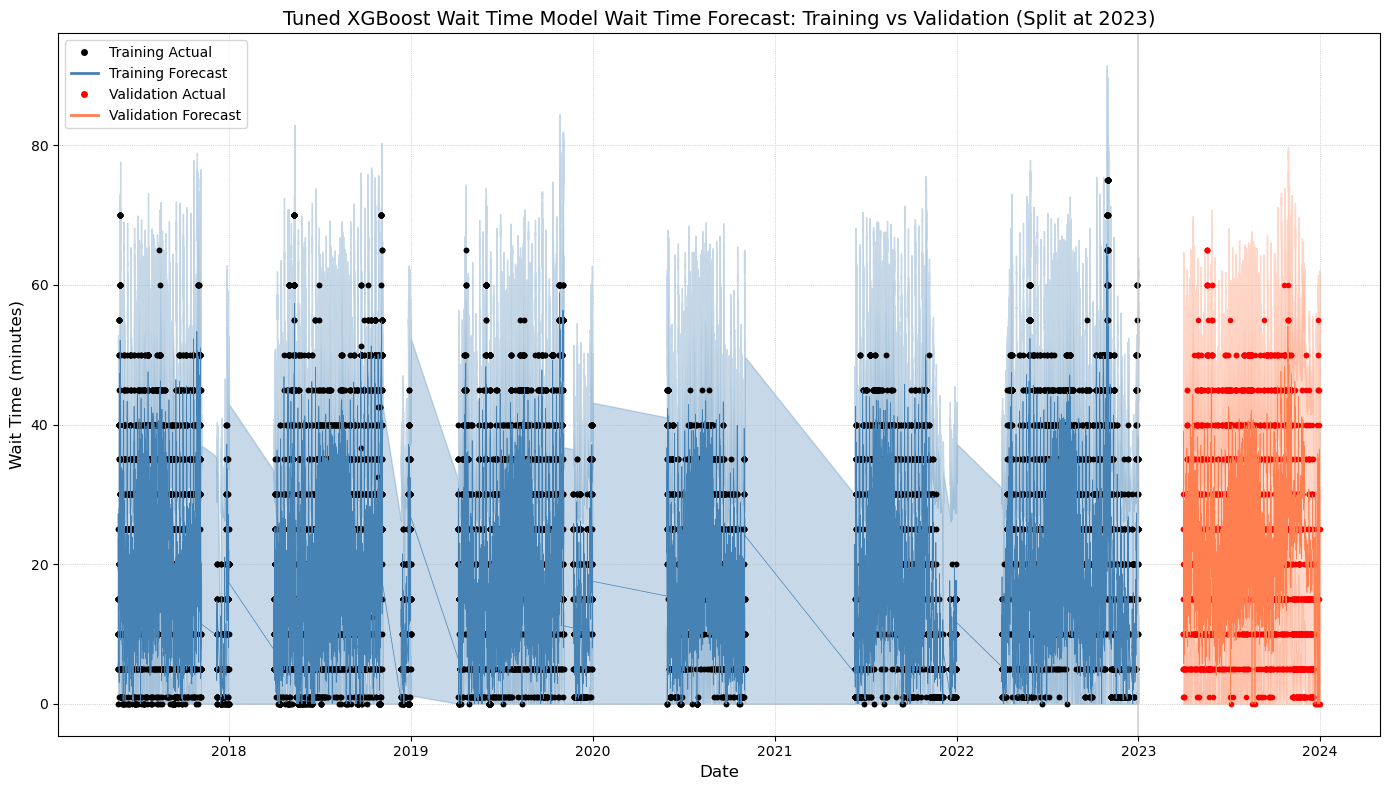


Tuned XGBoost Wait Time Model Evaluation:
MAE (Mean Absolute Error): 9.55 minutes
RMSE (Root-Mean-Square Deviation): 12.22 minutes
MAPE (Mean Absolute Percentage Error): 115.13%
Percentage of predictions within confidence interval: 95.58%


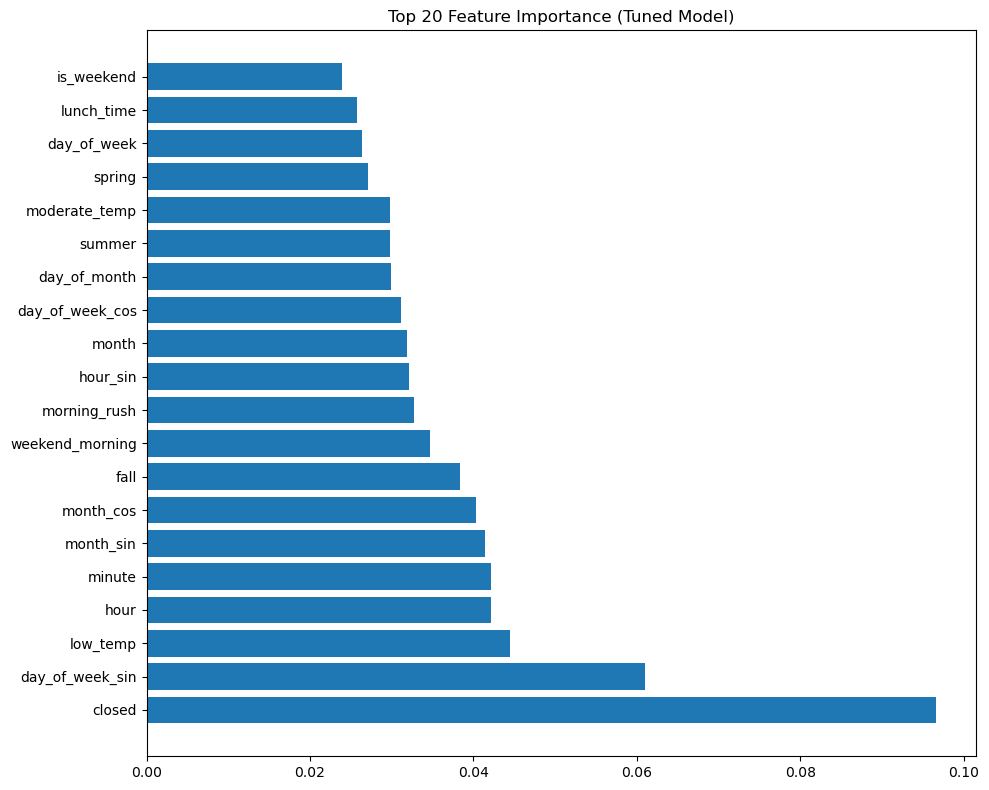

In [82]:
# Train the version-safe XGBoost model
print("\n---- Training Version-Safe XGBoost Wait Time Model ----")
xgb_model = VersionSafeXGBoostModel(lag_periods=[48, 96, 336, 672])  # 1 day, 2 days, 1 week, 2 weeks
xgb_model.fit(train_df, n_estimators=500, verbose=True)

# Optional: Perform cross-validation
print("\nPerforming cross-validation...")
cv_results = xgb_model.cross_validate(train_df, n_splits=5)

# Optional: Tune hyperparameters
print("\nPerforming hyperparameter tuning...")
# Define a smaller parameter grid for faster tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, 10],
    'n_estimators': [100, 300, 500, 1000],
    'subsample': [0.7, 0.9, 1.0, 1.2],
    'colsample_bytree': [0.3, 0.5, 0.7, 0.9]
}
tuning_results = xgb_model.tune_hyperparameters(train_df, param_grid=param_grid, n_iter=8)

# Generate predictions with the tuned model
xgb_forecast = xgb_model.predict(future)
xgb_forecast = post_process_forecast(xgb_forecast, baseline_df)
xgb_combined = combine_forecast_with_actual(xgb_forecast, train_df, val_df)

# Plot results
plot_forecast_comparison(xgb_combined, split_year=2023, show_uncertainty=True, 
                       model_name="Tuned XGBoost Wait Time Model")
plt.tight_layout()
plt.savefig("tuned_xgboost_forecast.png")
plt.show()

# Calculate error metrics
print("\nTuned XGBoost Wait Time Model Evaluation:")
xgb_metrics = calculate_error_metrics(xgb_combined, val_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(
    xgb_model.feature_importance.head(20)['Feature'],
    xgb_model.feature_importance.head(20)['Importance']
)
plt.title('Top 20 Feature Importance (Tuned Model)')
plt.tight_layout()
plt.savefig("tuned_xgboost_feature_importance.png")
plt.show()

# Define function to plot specific time periods

In [83]:
def plot_time_period(forecast_data, start_date, end_date, ax=None, show_uncertainty=True):
    """Plot forecast vs actual for a specific time period."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        
    df = forecast_data.loc[start_date:end_date,:]

    df.loc[:,'yhat'].plot(lw=2, ax=ax, color=VAL_COLOR, ls='-', label='Forecast')

    if show_uncertainty:
        ax.fill_between(df.index, df.loc[:,'yhat_lower'], df.loc[:,'yhat_upper'], 
                        color=VAL_FILL_COLOR, alpha=VAL_FILL_ALPHA)
    df.loc[:,'y'].plot(lw=2, ax=ax, color=TRAIN_COLOR, ls='-', label='Actual')

    ax.grid(ls=':')
    ax.legend(fontsize=15)
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    ax.set_ylabel('Wait time (minutes)', fontsize=15)
    ax.set_xlabel('', fontsize=15)

    start_date_weekday = pd.Timestamp(start_date).day_name()
    end_date_weekday = pd.Timestamp(end_date).day_name()
    ax.set_title(f'XGBoost: {start_date} ({start_date_weekday}) to {end_date} ({end_date_weekday})', fontsize=18)
    
    return ax

# Plot validation periods in detail

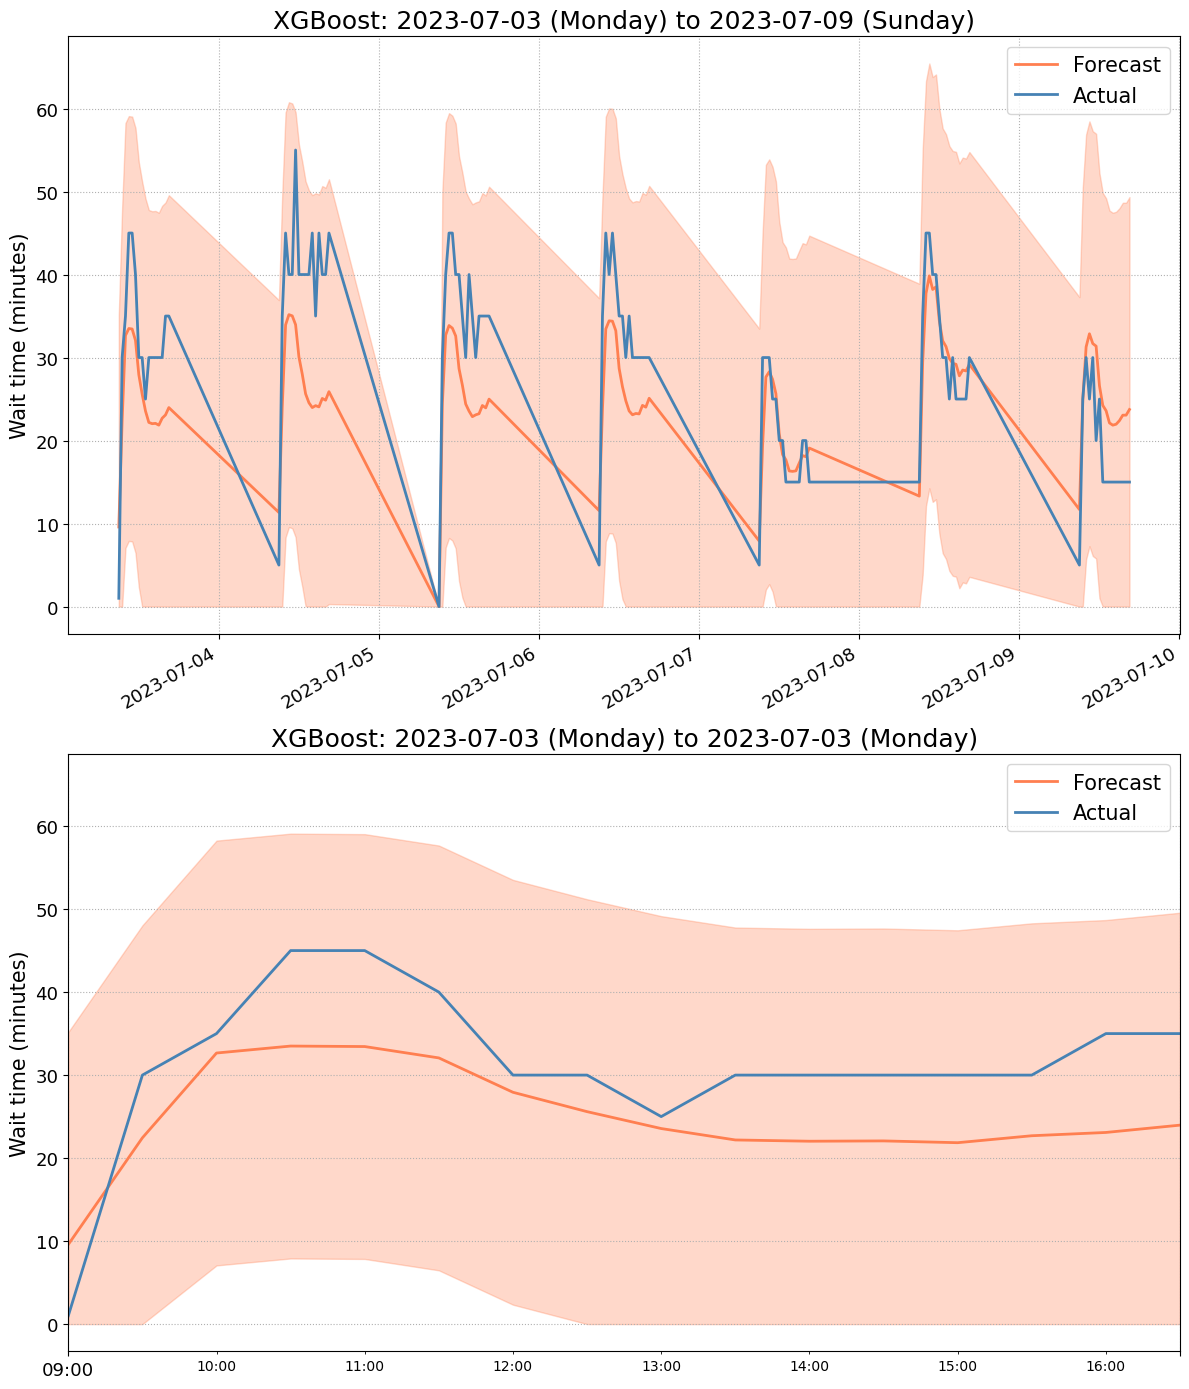

In [84]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 14), sharey=True)
plot_time_period(xgb_combined, '2023-07-03', '2023-07-09', ax=axes[0], show_uncertainty=True)
plot_time_period(xgb_combined, '2023-07-03', '2023-07-03', ax=axes[1], show_uncertainty=True)
plt.tight_layout()
plt.savefig("xgboost_detailed_view.png")
plt.show()